In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.random.set_seed(0)
np.random.seed(0)

import scipy.io as sio

2023-07-31 16:43:53.926353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 16:43:54.120754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/nvidia/cudnn/lib
2023-07-31 16:43:54.120769: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-31 16:43:55.878298: W tensorflow/compiler/xla/stream_executor/platform/default/ds

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 375392694514719554
xla_global_id: -1
]


2023-07-31 16:44:00.772826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 16:44:00.865760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 16:44:00.865995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/nvidia/cudnn/lib
2023-07-31 16:44:00.866636:

Number of 6s in the new dataset: 39
Number of 0s in the new dataset: 5923


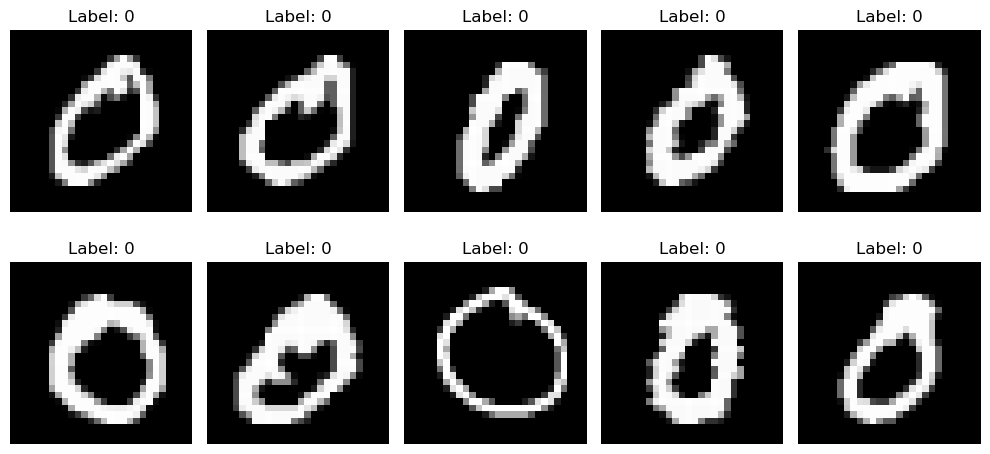

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter 6s from the dataset
indices_6 = np.where(y_train == 0)[0]
filtered_images = x_train[indices_6]
filtered_labels = y_train[indices_6]

# Select a few 0s
indices_0 = np.where(y_train == 6)[0][:len(indices_6) // 150]  # Select 1/5th of the number of 6s
selected_images = x_train[indices_0]
selected_labels = y_train[indices_0]

# Combine the selected images (6s) with the few 0s
combined_images = np.concatenate((filtered_images, selected_images))
combined_labels = np.concatenate((filtered_labels, selected_labels))

# Count the occurrences of each label (6 or 0) in the combined dataset
num_6s = np.sum(combined_labels == 6)
num_0s = np.sum(combined_labels == 0)

# Display the counts
print(f"Number of 6s in the new dataset: {num_6s}")
print(f"Number of 0s in the new dataset: {num_0s}")

# Visualize some samples from the custom dataset
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(combined_images[i], cmap='gray')
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save the custom dataset
np.savez_compressed('custom_mnist.npz', images=combined_images, labels=combined_labels)


Shape of reshaped images: (5962, 784)


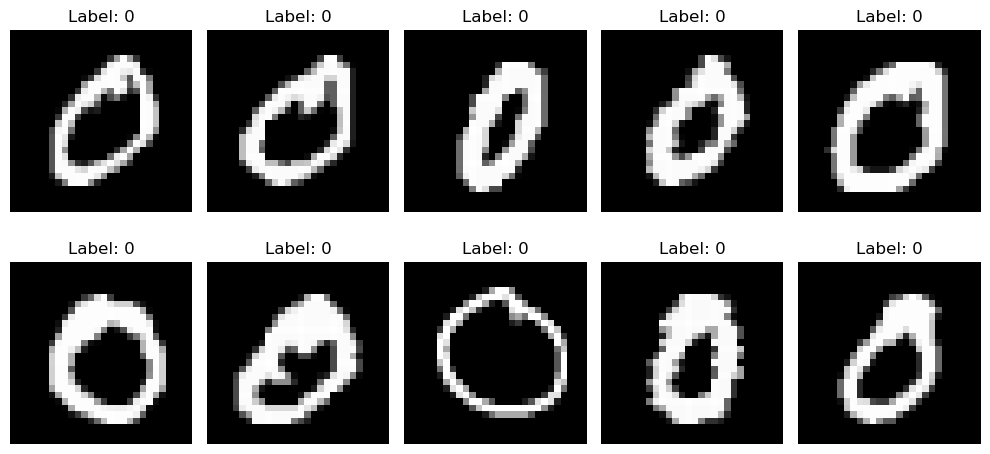

Original dataset shape: (5962, 28, 28)
Downsampled dataset shape: (5962, 15, 15)


In [3]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
# Load the custom dataset
custom_dataset = np.load('custom_mnist.npz')
combined_images = custom_dataset['images']
combined_labels = custom_dataset['labels']

# Reshape the images as 1D arrays
num_images = len(combined_images)
image_size = combined_images.shape[1] * combined_images.shape[2]
reshaped_images = combined_images.reshape(num_images, image_size)

# Display the shape of the reshaped images
print("Shape of reshaped images:", reshaped_images.shape)

# Visualize some reshaped images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(reshaped_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

output_size = (15, 15)

downsampled_images = np.zeros((combined_images.shape[0], *output_size))

# Downsample each image in the dataset
for i, image in enumerate(combined_images):
    downsampled_images[i] = zoom(image, (output_size[0] / image.shape[0], output_size[1] / image.shape[1]))

image_size = downsampled_images.shape[1] * downsampled_images.shape[2]
reshaped_images = downsampled_images.reshape(num_images, image_size)

# Verify the shape of the downsampled images
print("Original dataset shape:", combined_images.shape)
print("Downsampled dataset shape:", downsampled_images.shape)

normalized_images = reshaped_images / 255.0


In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



Training!
############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!
Training!


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############################# DONE!


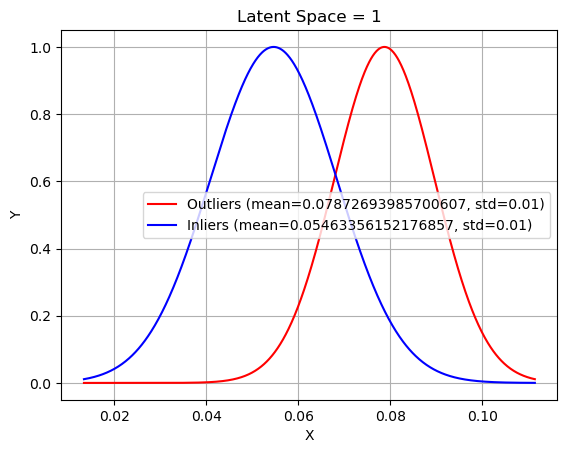

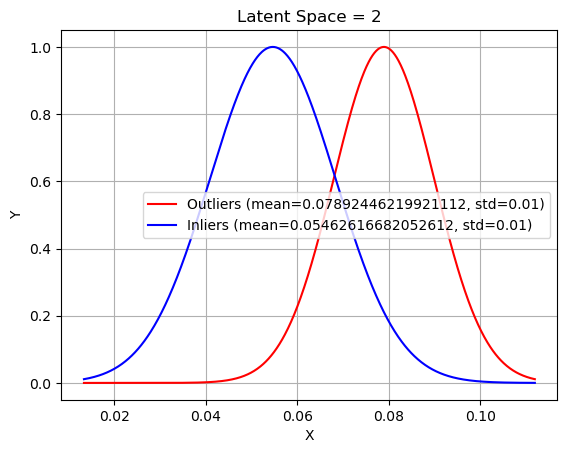

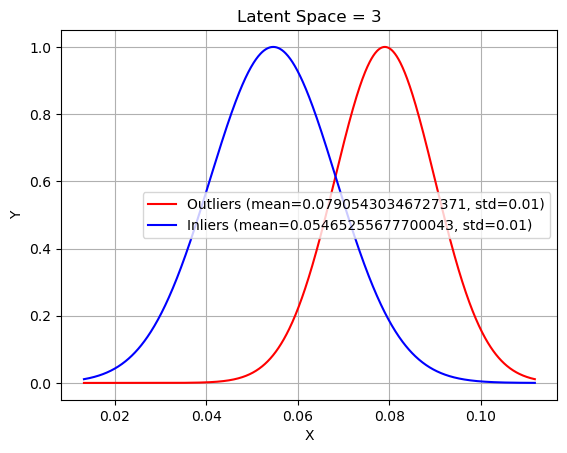

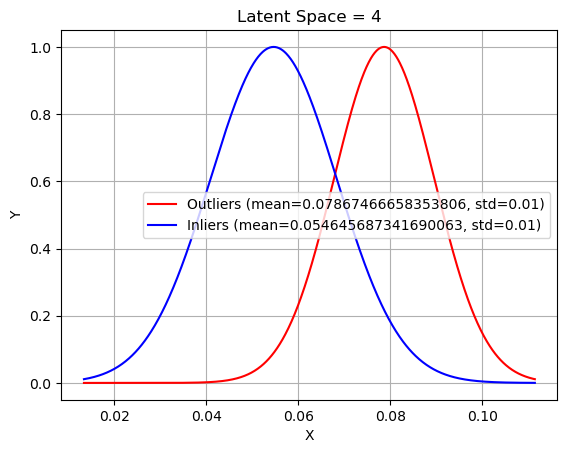

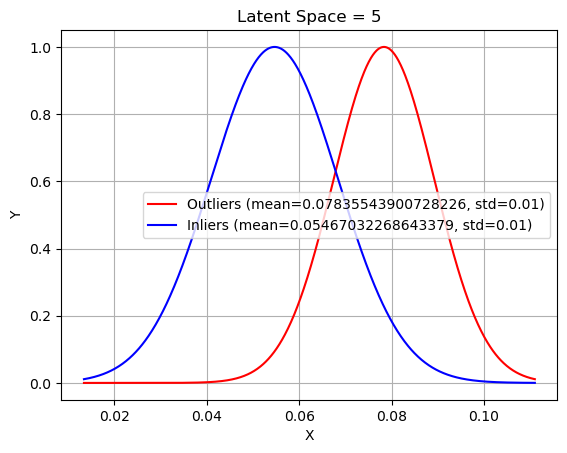

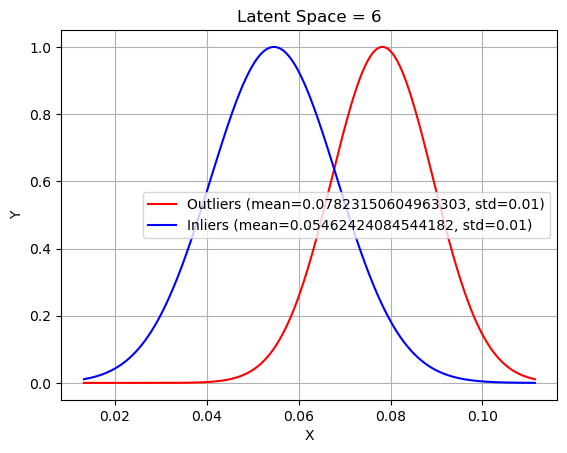

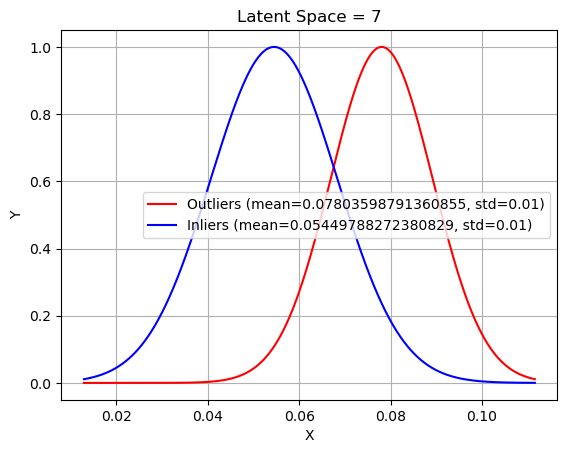

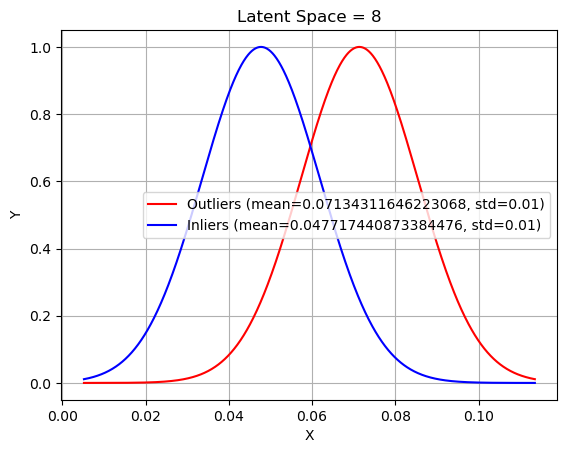

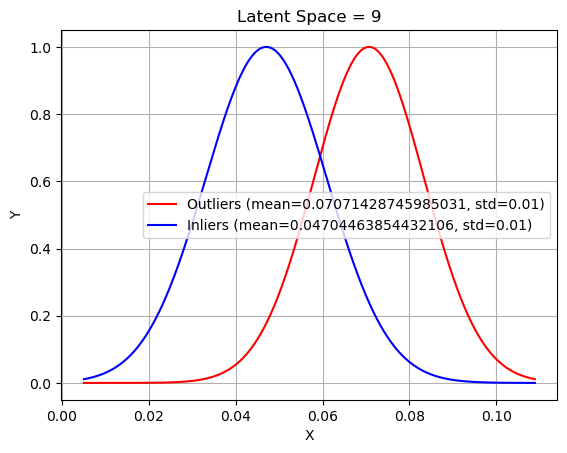

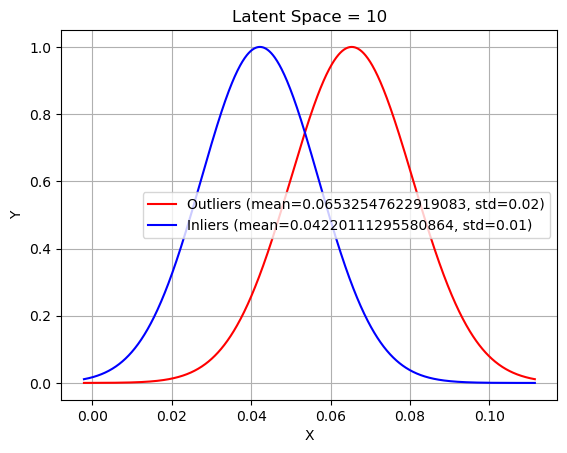

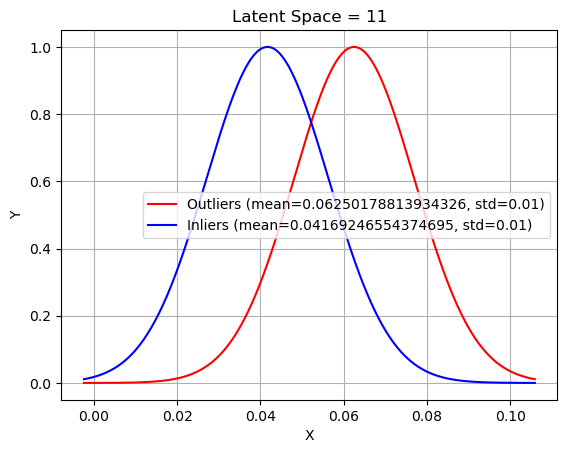

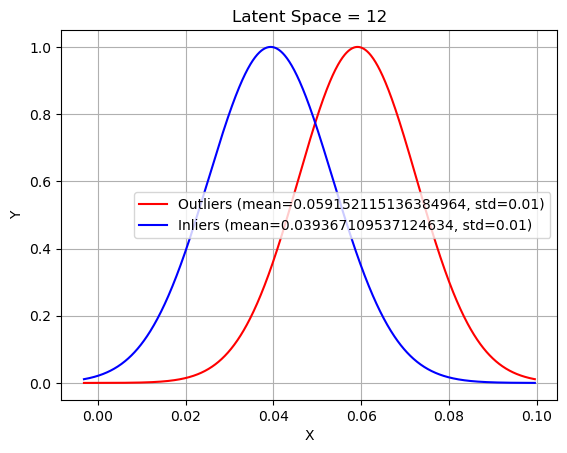

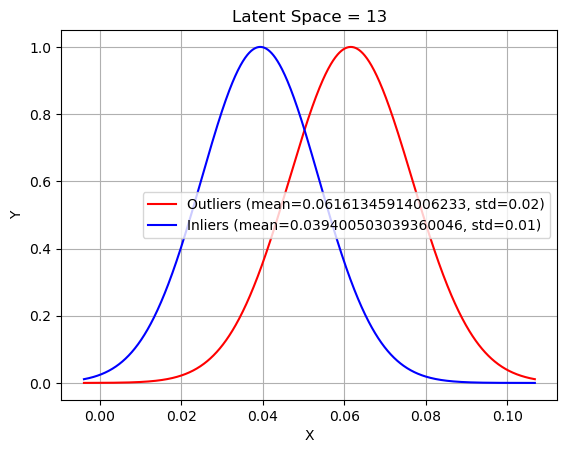

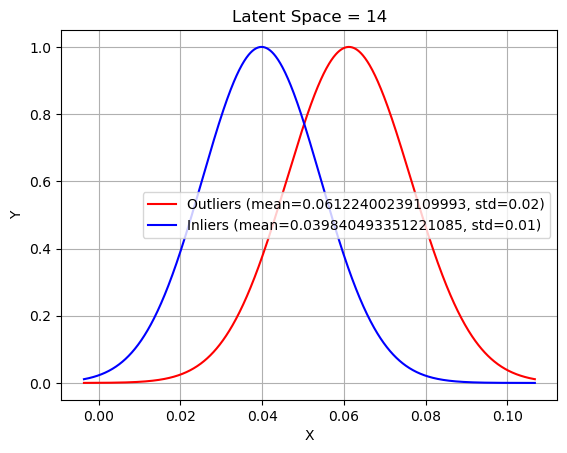

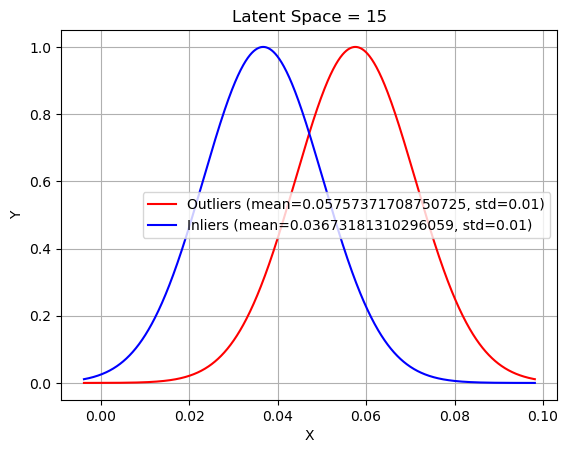

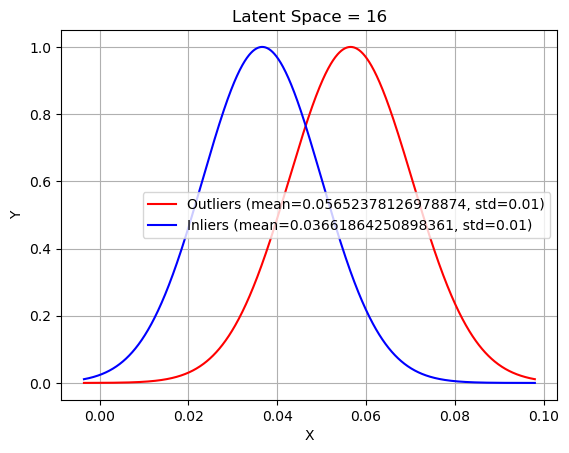

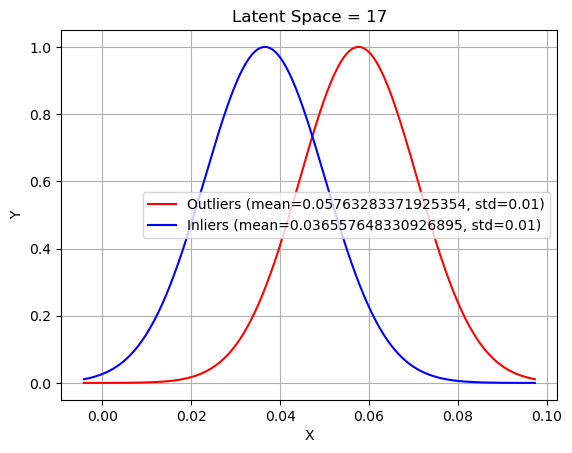

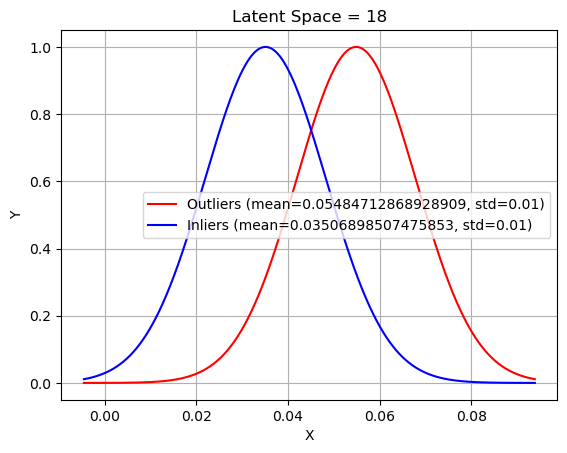

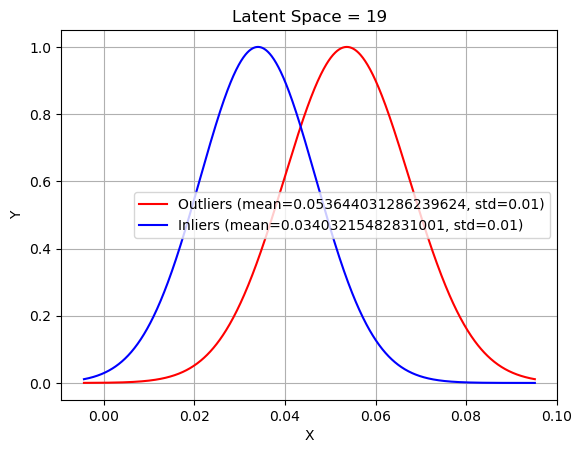

In [15]:
import numpy as np
import matplotlib.pyplot as plt

for latent_no in range(1,20):
    
    
    
    latent_dim = latent_no

    encoder_inputs = keras.Input(shape=(225,))
    # x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    # x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    # x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(encoder_inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    # x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    # x = layers.Reshape((7, 7, 64))(x)
    # x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    # x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    # decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    x = layers.Dense(64, activation="relu")(latent_inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(512, activation="relu")(x)
    decoder_outputs = layers.Dense(225, activation="tanh")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



    class VAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(data)
                reconstruction = self.decoder(z)
    #             reconstruction_loss = tf.reduce_mean(
    #                 tf.reduce_sum(
    #                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
    #                 )
    #             )
                reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
    #             reconstruction_loss = tf.keras.losses.BinaryCrossentropy()(data, reconstruction)
    #             
                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    #             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
                total_loss = reconstruction_loss +  0.08 * kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }

    # mnist_data = mat_data['X']
    tdata = np.concatenate([normalized_images], axis=0)
    tdata = np.expand_dims(tdata, -1).astype("float32")

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.legacy.Adam())
    print("Training!")
    history = vae.fit(tdata, epochs=100, batch_size=1024, verbose=0)
    
    
    out_rec = []
    mean_out_rec = []
    std_out_rec = []
    
    for io in range(10):

        for i in range(combined_labels.shape[0]):

            if combined_labels[i] == 6:

                sample = normalized_images[i,:].reshape([1,225])

                z_mean, z_log_var, z = vae.encoder(sample)
                reconstruction = vae.decoder(z)
                reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        #             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
                total_loss = reconstruction_loss +  0.08 * kl_loss


                out_rec.append(reconstruction_loss.numpy())

            out_mean = np.mean(np.array(out_rec))
            out_std = np.std(np.array(out_rec))
            
        mean_out_rec.append(out_mean)
        std_out_rec.append(out_std)
        
    mean_out_rec = np.mean(np.array(mean_out_rec))
    std_out_rec = np.mean(np.array(std_out_rec))

#     print("Mean = ", np.mean(np.array(out_rec)))
#     print("Std = ", np.std(np.array(out_rec)))


    out_rec = []

    for i in range(combined_labels.shape[0]):

        if combined_labels[i] == 0:

            sample = normalized_images[i,:].reshape([1,225])

            z_mean, z_log_var, z = vae.encoder(sample)
            reconstruction = vae.decoder(z)
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    #             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss +  0.08 * kl_loss


            out_rec.append(reconstruction_loss.numpy())
            
        in_mean = np.mean(np.array(out_rec))
        in_std = np.std(np.array(out_rec))

#     print("Mean = ", np.mean(np.array(out_rec)))
#     print("Std = ", np.std(np.array(out_rec)))




# Example usage:
    mean1 = mean_out_rec
    std1 = std_out_rec
    mean2 = in_mean
    std2 = in_std

    def gaussian(x, mean, std_dev, amplitude):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))

    # Parameters for the first Gaussian distribution
    # mean1 = 5
    std_dev1 = std1
    amplitude1 = 1

    # Parameters for the second Gaussian distribution
    # mean2 = 8
    std_dev2 = std2
    amplitude2 = 1

    # Generate x values
    x = np.linspace(min(mean1 - 3 * std_dev1, mean2 - 3 * std_dev2), max(mean1 + 3 * std_dev1, mean2 + 3 * std_dev2), 1000)

    # Calculate y values for both Gaussian distributions
    y1 = gaussian(x, mean1, std_dev1, amplitude1)
    y2 = gaussian(x, mean2, std_dev2, amplitude2)

    # Plot the Gaussian distributions
    plt.figure()
    plt.plot(x, y1, label=f"Outliers (mean={mean1}, std={std_dev1:.2f})", color='red')
    plt.plot(x, y2, label=f"Inliers (mean={mean2}, std={std_dev2:.2f})", color='blue')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Latent Space = ' + str(latent_no))
    plt.legend()
    plt.grid(True)
    plt.savefig('/home/macula/SMATousi/Desktop/Latent_Space = ' + str(latent_no) + '.png')
    
    
    print("############################# DONE!")
#     plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>